In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
from utils import parse_points3D, parse_cameras, parse_images, plot3D, remove_outliers, get_3D_box
from ransac import get_inplane_point_idx, ransac
from rigid import translate, get_vector_normal, get_rotation_matrix, rotate
from projection import forward_projection

In [2]:
points3D_txt = './home/points3D.txt'
data = parse_points3D(points3D_txt)
print(data.shape)

cameras_txt = './home/cameras.txt'
cameras = parse_cameras(cameras_txt)
print(cameras[1])

images_txt = './home/images.txt'
images = parse_images(images_txt)
# print(images)
print({k:v for k,v in images[1].items()})

(30624, 3)
{'MODEL': 'SIMPLE_RADIAL', 'WIDTH': 1920, 'HEIGHT': 1080, 'PARAMS': [1855.42, 960.0, 540.0, 0.00782192]}
{'QW': 0.995842, 'QX': -0.0167632, 'QY': -0.080855, 'QZ': -0.0384821, 'TX': 3.70913, 'TY': -1.19895, 'TZ': 1.91089, 'CAMERA_ID': 1, 'NAME': 'frame0.png'}


### Remove extreme outliers

In [3]:
data = remove_outliers(data, 4)
print(data.shape)

# outlier points: (79, 3)
# inlier points: (30545, 3)
(30545, 3)


### Run RANSAC to find dominant plane

In [4]:
sample_size = 3
num_iters = 20
threshold_inlier = 0.01
num_points = 1000
best_model, best_count = ransac(data, sample_size, num_iters, threshold_inlier, num_points)
print('best fit:', best_model, best_count)

iter 0: model param [-0.17142915 -0.23164905 -0.1253426   0.94933661], in plane point count 403
iter 1: model param [ 0.04157776 -0.04377599 -0.11098596  0.99198643], in plane point count 2479
iter 2: model param [ 0.15797547  0.16196857 -0.11553517  0.96719262], in plane point count 550
iter 3: model param [ 0.07586778 -0.00474969 -0.1298316   0.98861786], in plane point count 1261
iter 4: model param [ 0.01450039 -0.08640805 -0.09983053  0.99113937], in plane point count 3320
iter 5: model param [ 7.73834958e-04 -1.39048471e-01 -9.02893140e-02  9.86160618e-01], in plane point count 9170
iter 6: model param [ 0.0389148  -0.06710623 -0.12154644  0.98954982], in plane point count 1070
iter 7: model param [ 0.02306465 -0.11857991 -0.12459223  0.98482669], in plane point count 789
iter 8: model param [ 0.11703861 -0.02538618 -0.11576087  0.9860309 ], in plane point count 957
iter 9: model param [-0.02381912 -0.43964669 -0.0041143   0.89784548], in plane point count 506
iter 10: model para

In [5]:
inplane_point_idx = get_inplane_point_idx(best_model, data, threshold_inlier)
inplane_points = data[inplane_point_idx, :]
print('# inplane points:', inplane_points.shape)

mask = np.ones(len(data), np.bool)
mask[inplane_point_idx] = 0
outplane_points = data[mask]
print('# outplane points:', outplane_points.shape)

# inplane points: (18949, 3)
# outplane points: (11596, 3)


### XYZ coordinates

<IPython.core.display.Javascript object>


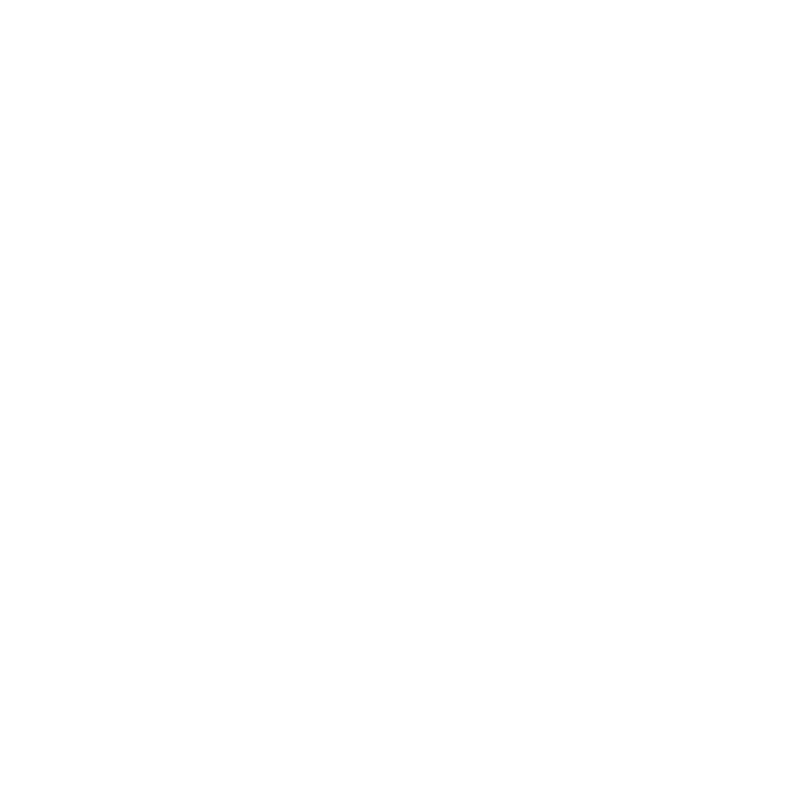

In [6]:
%matplotlib notebook
plot3D(inplane_points, outplane_points, plot_plane=False)

<IPython.core.display.Javascript object>


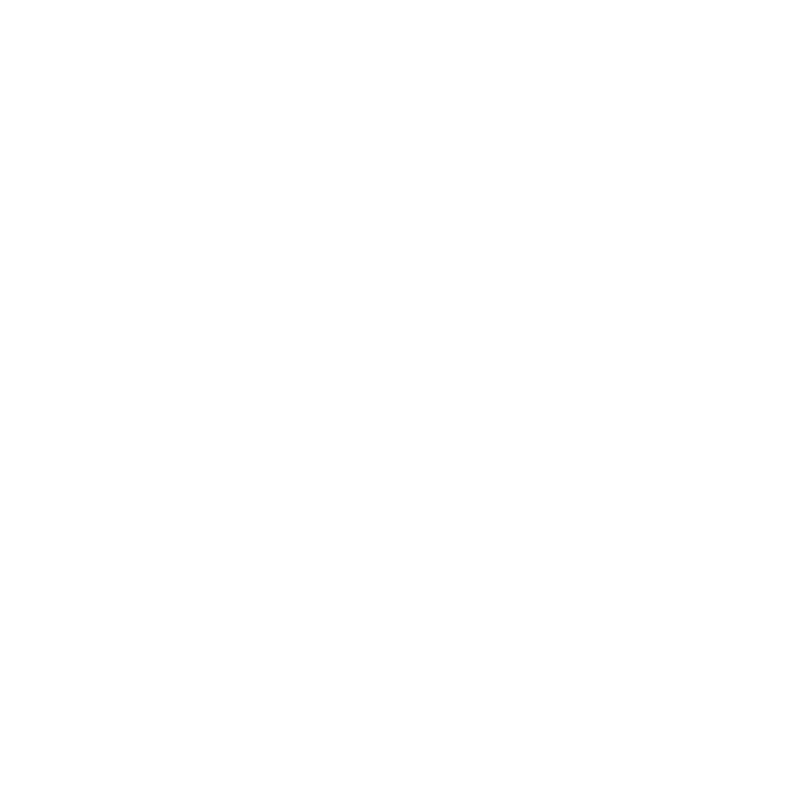

In [7]:
%matplotlib notebook
plot3D(inplane_points, outplane_points, plot_plane=True, model=best_model)

### Compute rotation matrix

In [8]:
center_XYZ = np.mean(inplane_points, axis=0)
center_XYZ = center_XYZ.reshape(1, 3)
inplane_points_centered = translate(inplane_points, -center_XYZ)
outplane_points_centered = translate(outplane_points, -center_XYZ)

In [9]:
normal_XYZ = get_vector_normal(best_model)
normal_xyz = np.array([0, 0, 1])

In [10]:
# R_xyz2XYZ = get_rotation_matrix(normal_xyz, normal_XYZ)
R_XYZ2xyz = get_rotation_matrix(normal_XYZ, normal_xyz)

In [11]:
inplane_points_local = rotate(inplane_points_centered, R_XYZ2xyz)
outplane_points_local = rotate(outplane_points_centered, R_XYZ2xyz)

### Local xyz coordinates

<IPython.core.display.Javascript object>


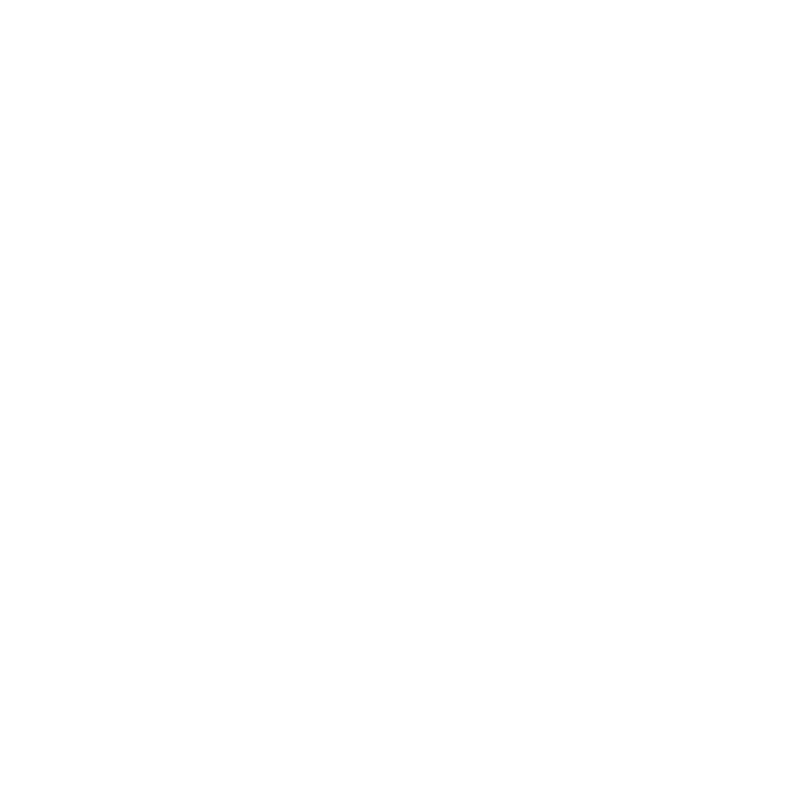

In [12]:
%matplotlib notebook
plot3D(inplane_points_local, outplane_points_local, plot_plane=False)

<IPython.core.display.Javascript object>


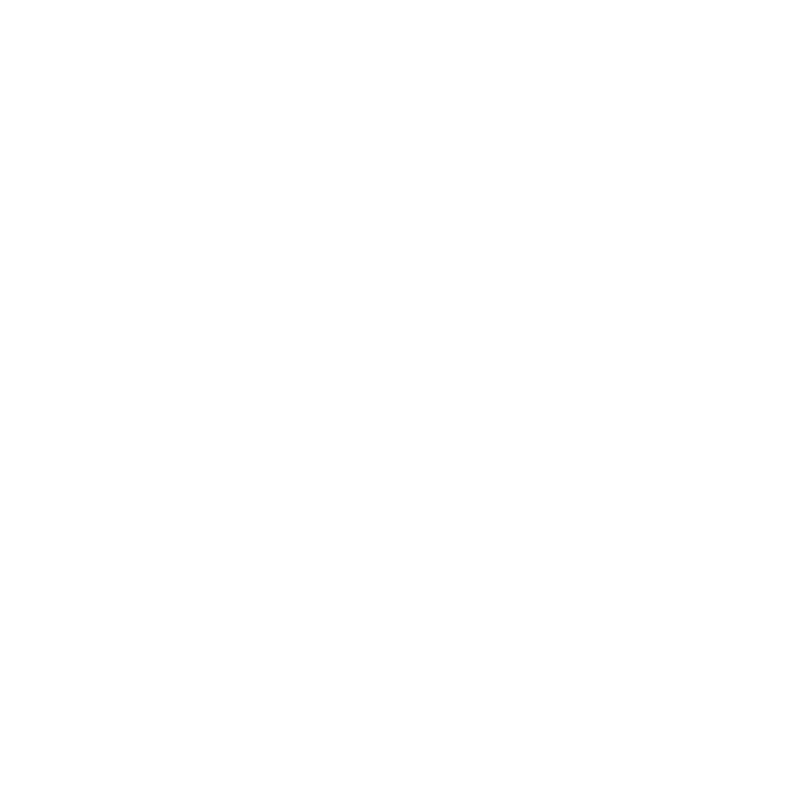

In [13]:
%matplotlib notebook
plot3D(inplane_points_local, outplane_points_local, plot_plane=True, model=np.array([0, 0, 1, 0]))

### Put a 3D box in local xyz coordinates

In [14]:
dimx, dimy, dimz = 3, 3, 1 # box dimension along axis
corners_local = get_3D_box(dimx, dimy, dimz)

<IPython.core.display.Javascript object>


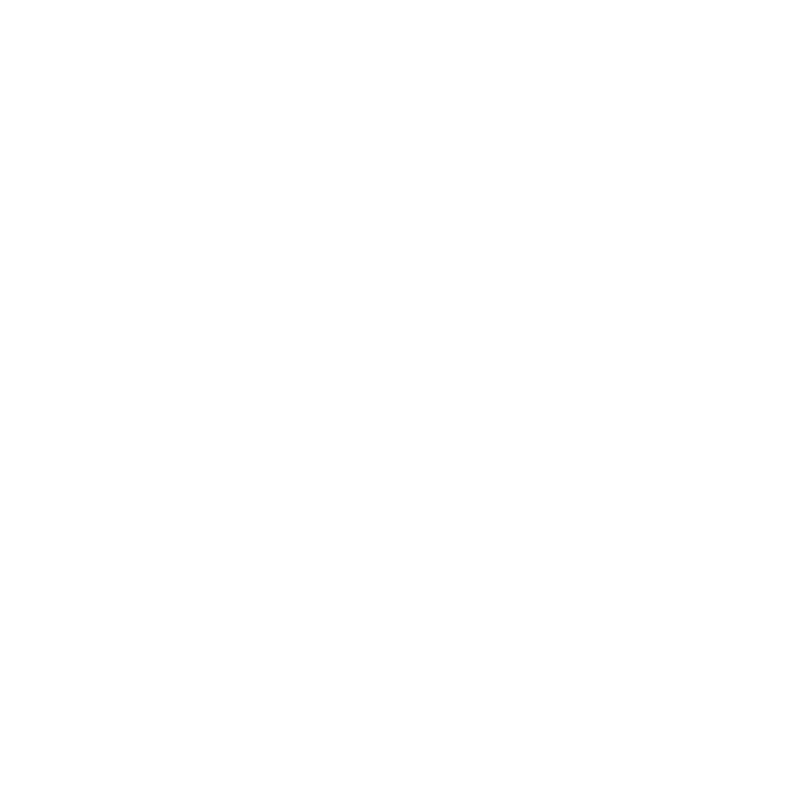

In [15]:
%matplotlib notebook
plot3D(inplane_points_local, outplane_points_local, plot_box=True, corners=corners_local)

### Convert local 3D box back to scene XYZ coordinates

In [16]:
R_xyz2XYZ = get_rotation_matrix(normal_xyz, normal_XYZ)
corners = rotate(corners_local, R_xyz2XYZ)
corners = translate(corners, center_XYZ)

<IPython.core.display.Javascript object>


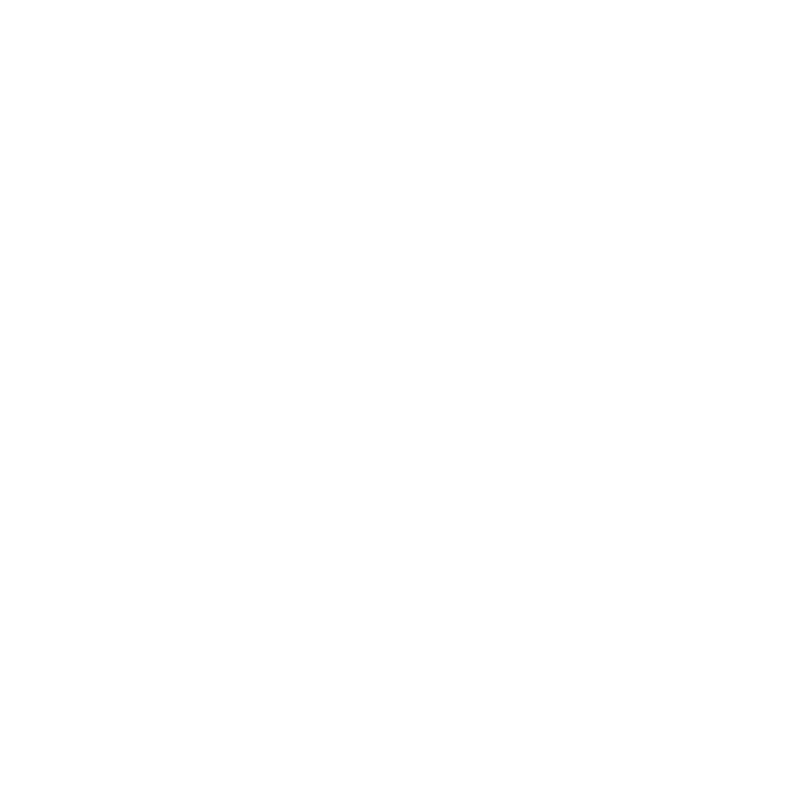

In [17]:
%matplotlib notebook
plot3D(inplane_points, outplane_points, plot_box=True, corners=corners)

### Check world -> image projection

In [28]:
# use 1st camera model and pose of 1st image
uv = forward_projection(data, cameras[1], images[1])
# remove key points outside of image plane
WIDTH = cameras[1]['WIDTH']
HEIGHT = cameras[1]['HEIGHT']
uv_trimmed = []
for u, v in uv:
    if 0 <= u < WIDTH and 0 <= v < HEIGHT:
        uv_trimmed.append([u, v])
uv_trimmed = np.array(uv_trimmed)

<IPython.core.display.Javascript object>


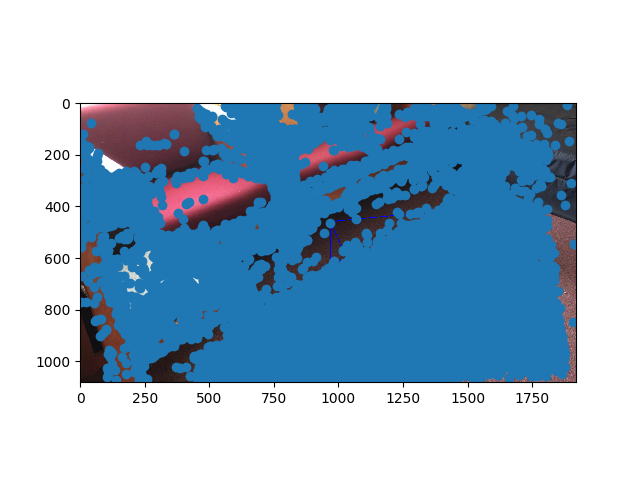

In [29]:
img = cv2.imread('./home/frames/frame0.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.scatter(uv_trimmed[:, 0], uv_trimmed[:, 1])
plt.show()

### Put virtual box on image

In [39]:
num_imgs = len(images)
i = 1 # index starts from 1
uv = forward_projection(corners, cameras[1], images[i])
uv

array([[1464,  559],
       [ 968,  615],
       [1115, 1009],
       [1745,  912],
       [1492,  410],
       [ 970,  461],
       [1128,  834],
       [1801,  741]])

In [40]:
img = cv2.imread('./home/frames/frame0.png')
combinations = [[0,1,2,3],  # bottom
                [4,5,6,7],  # top
                [0,1,5,4],  # right
                [3,2,6,7],  # left
                [0,4,7,3],  # front
                [1,5,6,2]]  # back
combinations = np.array(combinations)
for comb in combinations:
    vertices = uv[comb, :]
    p1, p2, p3, p4 = vertices
    cv2.line(img, tuple(p1), tuple(p2), (255,0,0), 2)
    cv2.line(img, tuple(p2), tuple(p3), (255,0,0), 2)
    cv2.line(img, tuple(p3), tuple(p4), (255,0,0), 2)
    cv2.line(img, tuple(p4), tuple(p1), (255,0,0), 2)

<IPython.core.display.Javascript object>


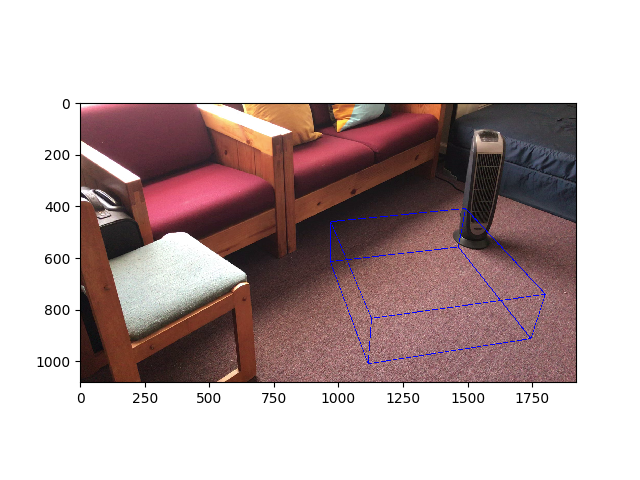

In [41]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()